# 2 - Modeling:

- Load data: load featurized data, supersample optional, format X=features and Y=label for sklearn models.
- Train model: Toggle random forest or logistic regression models
- Make predictions: Two sets of predictions (1) held out "test" set from training data (2) test_data.csv 749 new element pairs not in training set. Not labeled.  
- Evaluate: Generate confusion matrix, ROC curve and PR curve.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.family': 'lusitana'})

df = pd.read_csv('data/training_data_exploded_magpie_featurized.csv')
print(len(df))

28292


In [2]:
# super sample (uncomment for supersampling)

#stable_binaries = df[(df['stabilityVec'] == 1) & (df['FORMULA'].str.contains('\.'))]
#for i in range(3):
#    df = df.append(stable_binaries)
#print(len(df))

In [3]:
# lets see what we're working with. 
# Hypothesis: majority of binaries are unstable. Monoatomics will all be stable. This will create a large class imbalance.

def plot_classes(counts):
    
    fig = plt.figure(figsize=(6,6)) # default is (8,6)
    plt.bar([0, 1], [counts[0], counts[1]], color='green', width=0.5)
    plt.xticks([0,1])
    plt.yticks([0, 10e3, 20e3])
    plt.xlabel('0 = unstable, 1 = stable')
    plt.ylabel('counts')
    plt.show()
    fig.savefig('figures/classes.png')
    
    return

counts = df['stabilityVec'].value_counts()
stable_binaries = df[(df['stabilityVec'] == 1) & (df['FORMULA'].str.contains('\.'))]
unstable_binaries = df[(df['stabilityVec'] == 0) & (df['FORMULA'].str.contains('\.'))]
stable_monatomic = df[(df['stabilityVec'] == 1) & (~df['FORMULA'].str.contains('\.'))]
unstable_monatomic = df[(df['stabilityVec'] == 0) & (~df['FORMULA'].str.contains('\.'))]
print(counts)
print('stable binaries: ', len(stable_binaries))
print('unstable binaries: ', len(unstable_binaries))
print('stable monatomic: ', len(stable_monatomic))
print('unstable monatomic: ', len(unstable_monatomic))

#plot_classes(counts)

0.0    20655
1.0     7637
Name: stabilityVec, dtype: int64
stable binaries:  2493
unstable binaries:  20655
stable monatomic:  5144
unstable monatomic:  0


In [4]:
# define inputs and outputs: y = label(s), X=features
y = df['stabilityVec'].values

excluded = ['Unnamed: 0', 'FORMULA', 'composition', 'stabilityVec']
X = df.drop(excluded, axis=1)

print("There are {} possible descriptors:\n\n{}".format(X.shape[1], X.columns.values))

There are 120 possible descriptors:

['MagpieData minimum Number' 'MagpieData maximum Number'
 'MagpieData range Number' 'MagpieData mean Number'
 'MagpieData avg_dev Number' 'MagpieData mode Number'
 'MagpieData minimum MendeleevNumber' 'MagpieData maximum MendeleevNumber'
 'MagpieData range MendeleevNumber' 'MagpieData mean MendeleevNumber'
 'MagpieData avg_dev MendeleevNumber' 'MagpieData mode MendeleevNumber'
 'MagpieData minimum AtomicWeight' 'MagpieData maximum AtomicWeight'
 'MagpieData range AtomicWeight' 'MagpieData mean AtomicWeight'
 'MagpieData avg_dev AtomicWeight' 'MagpieData mode AtomicWeight'
 'MagpieData minimum Column' 'MagpieData maximum Column'
 'MagpieData range Column' 'MagpieData mean Column'
 'MagpieData avg_dev Column' 'MagpieData mode Column'
 'MagpieData minimum Row' 'MagpieData maximum Row' 'MagpieData range Row'
 'MagpieData mean Row' 'MagpieData avg_dev Row' 'MagpieData mode Row'
 'MagpieData minimum CovalentRadius' 'MagpieData maximum CovalentRadius'
 'Ma

In [5]:
# import classifiers and associated analysis methods
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

# since our test_data.csv is unlabeled, test-train split will allow for model eval.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

# initialize rf
classifier = RandomForestClassifier(n_estimators=20, random_state=1)
# classifier = LogisticRegression(random_state=1)

# fit to data
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [6]:
# make predictions
predictions = classifier.predict(X_test)

In [8]:
# analyze predictions
from sklearn.metrics import f1_score, confusion_matrix
conf = confusion_matrix(y_test, predictions)
tn, fp, fn, tp = conf.ravel()
print('True positives: ', tp)
print('False positives: ', fp)
print('True negatives: ', tn)
print('False negatives: ', fn)
accuracy = (tp+tn)/(tp+tn+fn+fp)
f1_score = f1_score(y_test, predictions)
print("F1 score: ", round(f1_score, 3))
print("Accuracy: ", round(accuracy, 3))

True positives:  1921
False positives:  141
True negatives:  6697
False negatives:  578
F1 score:  0.842
Accuracy:  0.923


AUC: 0.962


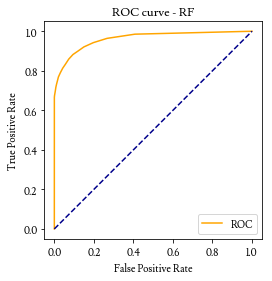

In [11]:
# Generate an ROC curve, for info on ROC curve see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#sphx-glr-auto-examples-model-selection-plot-roc-py
from sklearn.metrics import roc_auc_score, roc_curve
probs = classifier.predict_proba(X_test)
probs = probs[:, 1]
auc = roc_auc_score(y_test, probs)
print('AUC: %.3f' % auc)
fpr, tpr, thresholds = roc_curve(y_test, probs)

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve - RF')
    plt.legend()
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('figures/rf_supersample_roc_curve.png')
    plt.show()

plot_roc_curve(fpr, tpr)

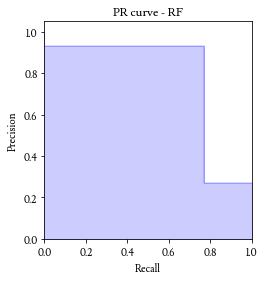

0.7780473531764666


In [12]:
# plot PR curve, for info on PR curve see: https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
from inspect import signature
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(recall, precision):
    step_kwargs = ({'step': 'post'} if 'step' in signature(plt.fill_between).parameters else {})
    plt.step(recall, precision, color='b', alpha=0.2, where='post')
    plt.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('PR curve - RF')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.savefig('figures/rf_supersample_pr_curve.png')
    plt.show()
    return

precision, recall, _ = precision_recall_curve(y_test, predictions)
average_precision = average_precision_score(y_test, predictions)
plot_pr_curve(recall, precision)
print(average_precision)

In [13]:
# Assess model quality using CV. 3-fold and 10-fold.
from sklearn.model_selection import cross_val_score, KFold
crossvalidation = KFold(n_splits=3, shuffle=False, random_state=1)
cv_score = cross_val_score(classifier, X, y, cv=crossvalidation, scoring='roc_auc')
avg_auroc = cv_score.mean()
print(avg_auroc)

0.9632988014853429


In [14]:
# investigate important features
feature_importances = pd.DataFrame(classifier.feature_importances_, index = X_train.columns, columns=['importance']).sort_values('importance', ascending=False)
print(feature_importances)

                                    importance
MagpieData range MendeleevNumber      0.071601
MagpieData avg_dev AtomicWeight       0.068320
MagpieData range GSvolume_pa          0.068017
MagpieData avg_dev MendeleevNumber    0.068004
MagpieData avg_dev GSvolume_pa        0.057959
...                                        ...
MagpieData maximum NsValence          0.000092
MagpieData minimum NpValence          0.000083
MagpieData minimum GSbandgap          0.000081
MagpieData minimum NsUnfilled         0.000030
MagpieData minimum NfUnfilled         0.000000

[120 rows x 1 columns]


In [15]:
# load test_data.csv, make predictions, output csv with predictions.
df_test = pd.read_csv('data/test_data_exploded_magpie_featurized.csv')
excluded = ['Unnamed: 0', 'FORMULA', 'composition']
X_test = df_test.drop(excluded, axis=1)
df_test['predicted_stabilityVec'] = classifier.predict(X_test)
df_test.to_csv('data/test_data_exploded_magpie_featurized_predictions_rf.csv')